<h1 style="font-family:Impact,Arial;font-size:50px">MWATS Statistics </h1>
<p> These data were extracted from the Variable and Slow Transients (VAST) pipeline in csv format and then converted to parquet format via the Load.ipynb script. In this notebook we apply filters and average the data on a daily cadence. We then generate a statistics table to explore the data. Some example plots have been included at the end of the script to plot locations of highly variable objects as well as exploring the overall statistics of the dataset. For more information contact: Martin.Bell@uts.edu.au.


## Data Columns
### _data_ table:

- **raw_peak_flux**: flux density [_JY - Janskys_] (or brightness of the observation).

- **source_name**  : unique identifier of a given source (or object). 

- **jd**          : Julian date [_D - days_].

- **ra** : Right Ascension [_Deg - Degrees_].

- **dec** : Declination [_Deg - Degrees_].

- **im_ra**: Image Right Ascension [_Deg - Degrees_] i.e. the RA of the pointing centre of the image from which the measurement was taken. 

- **im_dec**: Image Declination [_Deg - Degrees_] i.e. the Dec of the pointing centre of the image from which the measurement was taken. 

- **distance**: Distance [_Deg - Degrees_]: distance between pointing centre and flux measurement. 

- **gain**: Gain [no units]. Multiplicative factor that has been applied to each image (and flux measurements in image) to correct flux scale. Should be close to 1. 

### _data _avg_ table: 

- **median_flux** : median flux density [_JY - Janskys_] of daily measurements. 

- **std_flux** : standard deviation of daily flux measurements [_JY - Janskys_].

- **mean_jd** : mean Julian date of daily measurements [_D - days_]. 

- **datetime** : pandas datetime object of mean date of observations. 


### _stats_ table: 

- **mean_raw_peak_flux** : mean flux density of all measurements [_JY - Janskys_].	

- **std_raw_peak_flux**	 : standard deviation of all measurements [_JY - Janskys_].

- **Mod** Modulation Index [%].	

- **length**: Length of time series [_N_].
- **sig**: Significance of gradient [grad / fit_error].	
- **grad** : Linear regression fit to the data.	
- **fit_error** : Error on the linear regression. NOTE: error bars were not used in this fit as per Bell et al. 2018, only the scatter on the measurements. 	
- **y_int** : Y intercept of the linear fit.

- **avg_sig**: Significance of gradient [grad / fit_error] for daily median flux measurements.	
- **avg_grad** : Linear regression fit to the data for daily median flux measurements.	

- **avg_fit_error** : Error on the linear regression for daily median flux measurements. NOTE: error bars were not used in this fit as per Bell et al. 2018, only the scatter on the measurements. 	

- **avg_y_int** : Y intercept of the linear fit for daily median flux measurements.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

import warnings
warnings.simplefilter('ignore')

import time

import nmslib;

In [2]:
def distance_from_median_pos(df):
    degrees_to_radians = np.pi/180.0
    phi1 = df.dec*degrees_to_radians
    phi2 = df.median_dec*degrees_to_radians

    theta1 = df.ra*degrees_to_radians
    theta2 = df.median_ra*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

## Loading the data
The input data file is the feather file created in Load.ipynb

In [3]:
data = pd.read_feather('mwats_raw_data_Apr_SQL.fth')

In [4]:
# Add in columns for median RA/DEC and flux.
tmp3 = data.groupby('source_id')[['ra','dec','raw_peak_flux']].median().reset_index() 
tmp3.columns = ['source_id', 'median_ra', 'median_dec', 'median_flux']
data = pd.merge(data,
                 tmp3[['source_id', 'median_ra', 'median_dec', 'median_flux']],
                 on='source_id')

In [5]:
# Add in columns for std RA/DEC and flux.
tmp4 = data.groupby('source_id')[['ra','dec']].std().reset_index() 
tmp4.columns = ['source_id', 'std_ra', 'std_dec']
data = pd.merge(data,
                 tmp4[['source_id', 'std_ra', 'std_dec']],
                 on='source_id')

In [6]:
# Add offet and flux_offset data columns. 
# offset = distance (in deg) from median position. 
# flux_offset = measured flux minus the median
data['offset'] = distance_from_median_pos(data)
data['flux_offset'] = np.sqrt((data.raw_peak_flux-data.median_flux)**2)

## Filtering: 
Below are the filters that have been applied to the data. These can be modified based on the users requirement. 

- _Distance from pointing centre_: We filter measurements less than 12 degrees from the pointing centre as per Bell et al. 2016, 2018. Before filtering we have 10 million flux measurements and after filtering 6.2 million. It is quite subjective to define the correct distance, but 12 degrees has worked well in the past.  

- _max__flux_: The brightest object to consider in the analysis. Objects > 50 Jy are typically so bright they cause problems (in imaging) and are hard to generate reliable light-curves. 

- _min__length_: The minimum nimber of points to consider in the light-curves. Objects with small numbers of measurements may be spurius and unrealiable.  



In [7]:
# Filters (some are applied later in the script)
max_dist   = 15.0 # Only use measurements less that 12-15 degrees from pointing centre of the image.
max_flux   = 50.0 # Jy. Only consider sources with a maximum flux of max_flux.
min_flux   = 0.25 # Jy. Only consider sources with a minimum flux of min_flux.
min_length = 35 # Minimum length of time-series to consider. 
max_rms    = 500 # Remove images with RMS greater than this. A few RFI soaked images crept threw. 
min_rms    = 25  # A couple of badly calibrated images need to be removed. 
max_offset = 0.0375 # beam = 3 pixels with width @ 0.75' per pixel (0.75*3)/60 = 0.0375
max_flux_offset = 5000 # flux_offset = |flux - median_flux| = Gets ride of small number of bad fits

## Apply distance from pointing centre filter:

In [8]:
data = data[data.distance < max_dist]

## Apply rms image filters:

In [9]:
data = data[data.rms < max_rms]
data = data[data.rms > min_rms]

## Apply position offset filter:

In [10]:
# Remove data points more than 3 pixels away from median position
data = data[data.offset < max_offset] # beam = 3 pixels with width @ 0.75' per pixel (0.75*3)/60 = 0.0375

## Apply flux offset filter:

In [11]:
# Remove sources with really large flux offsets. They are just junk.
data = data[data.flux_offset < max_flux_offset]

## Remove sources that have more than one measurement in an image: 

In [12]:
good_sources = (data
                .groupby(['image_id','source_id'])
                .size().rename('count').to_frame()
                .reset_index().query('count == 2')['source_id']
               ).values
data = data[~data.source_id.isin(good_sources)]

## Remove a set of bad images

In [13]:
flag_bad_images = (data['time'] > '2014-02-11 00:00:00') \
                & (data['time'] < '2014-02-11 23:59:00') \
                & (data['im_dec'] > -26.9) \
                & (data['im_dec'] < -26.4) 

bad_images = data.loc[flag_bad_images]['cube_id'].values
data = data[~data.cube_id.isin(bad_images)]

## House keeping

In [14]:
# Set the date as the index
data.set_index('time', inplace=True)

# Remove sources without a source_id
data = data[data.source_id.notnull()]

# Convert source_id to int
data['source_id'] = data.source_id.astype(int)

## Averaging the full dataset
The steps below re-sample the raw data on day timescales.  

In [15]:
data_avg = (data.groupby(['source_id', pd.Grouper(freq = '1d')])
                .agg({
                        'raw_peak_flux': ['median', 'std'],
                        'jd': 'mean'
                     })
                .dropna()
           )

data_avg.columns = data_avg.columns.map('_'.join)

data_avg = (data_avg
                .rename(columns={
                    'raw_peak_flux_median': 'median_flux',
                    'raw_peak_flux_std': 'std_flux',
                    'jd_mean': 'mean_jd'
                                })
                .reset_index())


## Generate non-averaged statistics table

In [16]:
# Generate a new stats table with the mean flux of the non-averaging sources
stats_table = data.groupby('source_id')[['ra','dec','raw_peak_flux']].mean().reset_index() 
stats_table.columns = ['source_id', 'ra', 'dec', 'mean_raw_peak_flux']

# Add in the std
tmp = data.groupby('source_id')['raw_peak_flux'].std(ddof=1).reset_index()
tmp.columns = ['source_id', 'std_raw_peak_flux']
stats_table['std_raw_peak_flux'] = tmp['std_raw_peak_flux']

# Calculate the modulation index
stats_table['Mod'] = (stats_table.std_raw_peak_flux / stats_table.mean_raw_peak_flux) * 100 # In percent

# Add in a column with the number of measurements per source. 
tmp2 = data.groupby('source_id')['raw_peak_flux'].count().reset_index()
tmp2.columns = ['source_id', 'length']
stats_table['length'] = tmp2['length']

# Do some basic filtering of df to get rid of junky data points
stats_table = stats_table[(stats_table.mean_raw_peak_flux > 0) & (stats_table.std_raw_peak_flux > 0)]

# Do some astronomy based filtering
stats_table = stats_table[(stats_table.mean_raw_peak_flux > min_flux)
     & (stats_table.mean_raw_peak_flux < max_flux)
     & (stats_table.length > min_length)]

filtered_raw_data = data[data.source_id.isin(stats_table.source_id)]

In [17]:
daily = filtered_raw_data.groupby(['source_id', pd.Grouper(freq = '1d')])['raw_peak_flux'].apply(list)
daily = daily.reset_index().drop('time', axis=1).groupby('source_id').raw_peak_flux.apply(list)
anova = daily.apply(lambda x: pd.Series(stats.f_oneway(*x))).rename_axis({0:'F_a', 1:'p_a'}, axis=1)
kruskal = daily.apply(lambda x: pd.Series(stats.kruskal(*x))).rename_axis({0:'F_k', 1:'p_k'}, axis=1)

# Add ANOVA columns
stats_table = stats_table.merge(anova, left_on='source_id', right_on='source_id')

# Add KRUSKAL
stats_table = stats_table.merge(kruskal, left_on='source_id', right_on='source_id')

In [18]:
stats_table.head()

,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k
0,3045,22.932674,-70.002974,0.549114,0.089963,16.383230,37,6.124111,1.392324e-04,19.958179,0.010495
1,3054,29.589072,-69.987369,0.457230,0.102916,22.508633,39,14.646339,1.407048e-08,21.099103,0.012218
2,3070,352.690179,-69.952318,0.643379,0.087836,13.652342,44,1.924037,8.170486e-02,13.591212,0.137628
3,3081,11.677428,-69.953863,0.987332,0.070340,7.124215,47,1.270309,2.852528e-01,11.896277,0.219220
4,3083,20.446343,-69.950554,0.941916,0.065241,6.926389,47,0.672877,7.119657e-01,4.913830,0.766745


 ##  Calculate the gradient (non-averaged)

In [19]:
# Get the dates and fluxes
dates  = filtered_raw_data.groupby('source_id')['jd'].apply(list)
fluxes = filtered_raw_data.groupby('source_id')['raw_peak_flux'].apply(list)

# Concat time and flux and do the fit
time_flux = pd.concat((dates, fluxes), axis=1)
grad_fit = time_flux.apply(lambda x: linregress(x['jd'], x['raw_peak_flux']), axis=1)

# Calculate all of the terms
grad = grad_fit.map(lambda x: x.slope)
fit_error = grad_fit.map(lambda x: x.stderr)
sig = grad_fit.map(lambda l: l.slope/l.stderr)
y_int = grad_fit.map(lambda x: x.intercept)

stats_table = stats_table.assign(sig=sig.values)
stats_table = stats_table.assign(grad=grad.values)
stats_table = stats_table.assign(fit_error=fit_error.values)
stats_table = stats_table.assign(y_int=y_int.values)

## Generate averaged statistics

In [20]:
# We want to work with the sources in our filtered stats table (i.e. have decent sized light-curves).
filtered_raw_avg_data = data_avg[data_avg.source_id.isin(stats_table.source_id)]

In [21]:
# Get the dates and fluxes
dates  = filtered_raw_avg_data.groupby('source_id')['mean_jd'].apply(list)
fluxes = filtered_raw_avg_data.groupby('source_id')['median_flux'].apply(list)

In [22]:
# Concat time and flux and do the fit
time_flux = pd.concat((dates, fluxes), axis=1)
grad_fit = time_flux.apply(lambda x: linregress(x['mean_jd'], x['median_flux']), axis=1)

In [23]:
# Calculate all of the terms and add them to the stats table
avg_grad = grad_fit.map(lambda x: x.slope)
avg_fit_error = grad_fit.map(lambda x: x.stderr)
avg_sig = grad_fit.map(lambda l: l.slope/l.stderr)
avg_y_int = grad_fit.map(lambda x: x.intercept)

stats_table = stats_table.assign(avg_sig=avg_sig.values)
stats_table = stats_table.assign(avg_grad=avg_grad.values)
stats_table = stats_table.assign(avg_fit_error=avg_fit_error.values)
stats_table = stats_table.assign(avg_y_int=avg_y_int.values)

In [24]:
stats_table.set_index('source_id', inplace=True) # The indices of stats and tmp3 and tmp4 must be aligned. Let's set them to source_id

In [25]:
# Calculate the modulation index of the daily median flux measurements. 

# Add in the std of all the daily resampled measurements.
tmp3 = filtered_raw_avg_data.groupby('source_id')['median_flux'].std(ddof=1).reset_index()
tmp3.columns = ['source_id', 'avg_std']
tmp3.set_index('source_id', inplace=True)
stats_table['avg_std'] = tmp3['avg_std']

# Calculate the mean of the median daily flux measurements. 
tmp4 = filtered_raw_avg_data.groupby('source_id')['median_flux'].mean().reset_index()
tmp4.columns = ['source_id', 'avg_median']
tmp4.set_index('source_id', inplace=True)
stats_table['avg_median'] = tmp4['avg_median']

# Calculate the modulation index
stats_table['avg_Mod'] = (stats_table.avg_std / stats_table.avg_median) * 100 # In percent

In [26]:
stats_table.reset_index(inplace=True)
filtered_raw_avg_data.reset_index(inplace=True)
filtered_raw_data.reset_index(inplace=True)

# Nearest neighbours

Using https://github.com/nmslib/nmslib/blob/master/python_bindings/notebooks/search_vector_dense_optim.ipynb
with Euclidean distance.

In [27]:
source_positions = filtered_raw_data.groupby('source_id')[['ra', 'dec']].mean()
#source_positions = data.groupby('source_id')[['ra', 'dec']].mean()
source_positions.shape

(69459, 2)

In [28]:
source2idx = {s: i for i, s in enumerate(source_positions.index.values)}
idx2source = {v:k for (k, v) in source2idx.items()}
X = source_positions.values

In [29]:
# Set index parameters
# These are the most important ones
M = 15
efC = 100

num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
print('Index-time parameters', index_time_params)

# Number of neighbors 
K=100

# Space name should correspond to the space name 
# used for brute-force search
space_name='l2'

# Intitialize the library, specify the space, the type of the vector and add data points 
index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
index.addDataPointBatch(X)

# Create an index
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params) 
end = time.time() 
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

# Setting query-time parameters
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

query_qty = X.shape[0]
start = time.time() 
nbrs = index.knnQueryBatch(X, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty))

Index-time parameters {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0}
Index-time parameters {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100}
Indexing time = 1.307903
Setting query-time parameters {'efSearch': 100}
kNN time total=1.347560 (sec), per query=0.000019 (sec), per query adjusted for thread number=0.000078 (sec)


In [30]:
# Unpack the neighbours array into a dataframe

source_id = []
n_id1 = []
n_id2 = []
n_id3 = []
n_id4 = []
n_id5 = []

for n in nbrs:
    tmp_id = idx2source[n[0][0]]
    tmp_id1 = idx2source[n[0][1]]
    tmp_id2 = idx2source[n[0][2]]
    tmp_id3 = idx2source[n[0][3]]
    tmp_id4 = idx2source[n[0][4]]
    tmp_id5 = idx2source[n[0][5]]
    
    source_id.append(tmp_id)
    n_id1.append(tmp_id1)
    n_id2.append(tmp_id2)
    n_id3.append(tmp_id3)
    n_id4.append(tmp_id4)
    n_id5.append(tmp_id5)

In [31]:
neighbours = pd.DataFrame(
    {'source_id': source_id,
     'n_id1': n_id1,
     'n_id2': n_id2,
     'n_id3': n_id3,
     'n_id4': n_id4,
     'n_id5': n_id5,
     'source_id_ra'   : stats_table.set_index('source_id').loc[source_id].ra,
     'source_id_dec'  : stats_table.set_index('source_id').loc[source_id].dec,
      })

In [32]:
neighbours = neighbours.drop("source_id", axis=1)
neighbours = neighbours.reset_index()

In [33]:
n_id1_ra = stats_table.set_index('source_id').loc[n_id1].ra
n_id1_dec = stats_table.set_index('source_id').loc[n_id1].dec
n_id2_ra = stats_table.set_index('source_id').loc[n_id2].ra
n_id2_dec = stats_table.set_index('source_id').loc[n_id2].dec
n_id3_ra = stats_table.set_index('source_id').loc[n_id3].ra
n_id3_dec = stats_table.set_index('source_id').loc[n_id3].dec
n_id4_ra = stats_table.set_index('source_id').loc[n_id4].ra
n_id4_dec = stats_table.set_index('source_id').loc[n_id4].dec
n_id5_ra = stats_table.set_index('source_id').loc[n_id5].ra
n_id5_dec = stats_table.set_index('source_id').loc[n_id5].dec

neighbours = neighbours.assign(n_id1_ra=n_id1_ra.values)
neighbours = neighbours.assign(n_id1_dec=n_id1_dec.values)
neighbours = neighbours.assign(n_id2_ra=n_id2_ra.values)
neighbours = neighbours.assign(n_id2_dec=n_id2_dec.values)
neighbours = neighbours.assign(n_id3_ra=n_id3_ra.values)
neighbours = neighbours.assign(n_id3_dec=n_id3_dec.values)
neighbours = neighbours.assign(n_id4_ra=n_id4_ra.values)
neighbours = neighbours.assign(n_id4_dec=n_id4_dec.values)
neighbours = neighbours.assign(n_id5_ra=n_id5_ra.values)
neighbours = neighbours.assign(n_id5_dec=n_id5_dec.values)

In [34]:
def vectorized_distance_on_unit_sphere(s1_ra, s2_ra, s1_dec, s2_dec):
    degrees_to_radians = np.pi/180.0
    phi1 = s1_dec*degrees_to_radians
    phi2 = s2_dec*degrees_to_radians

    theta1 = s1_ra*degrees_to_radians
    theta2 = s2_ra*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

In [35]:
neighbours['dist_1'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id1_ra, neighbours.source_id_dec, neighbours.n_id1_dec)
neighbours['dist_2'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id2_ra, neighbours.source_id_dec, neighbours.n_id2_dec)
neighbours['dist_3'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id3_ra, neighbours.source_id_dec, neighbours.n_id3_dec)
neighbours['dist_4'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id4_ra, neighbours.source_id_dec, neighbours.n_id4_dec)
neighbours['dist_5'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id5_ra, neighbours.source_id_dec, neighbours.n_id5_dec)

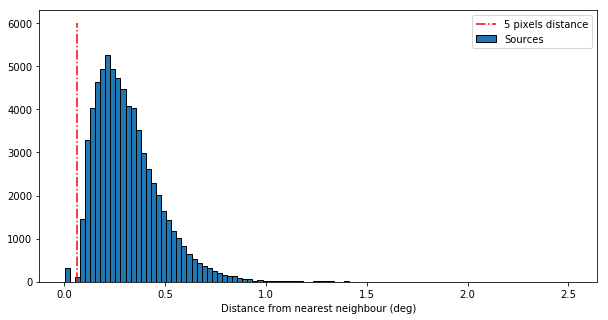

In [36]:
#ax=np.log10(neighbours.dist_0).hist(bins=100, figsize=(10, 5), grid=False, ec='k')
ax=(neighbours.dist_1).hist(bins=100, figsize=(10, 5), grid=False, ec='k', label='Sources')
plt.plot([0.0625,0.0625],[0,6000], 'r-.', label='5 pixels distance')
plt.xlabel('Distance from nearest neighbour (deg)')
plt.legend()

## Filter out sources that are closer than x pixels

In [37]:
# Filter out the nearby sources
pixel_distance = 5.0
close_source = neighbours[neighbours.dist_1 > (0.0125*pixel_distance)] # > 5 pixels ADD AS PARAMETER ABOVE
stats_table = stats_table[stats_table.source_id.isin(close_source.source_id)] # Do stats table only, leave in place in data tables. 

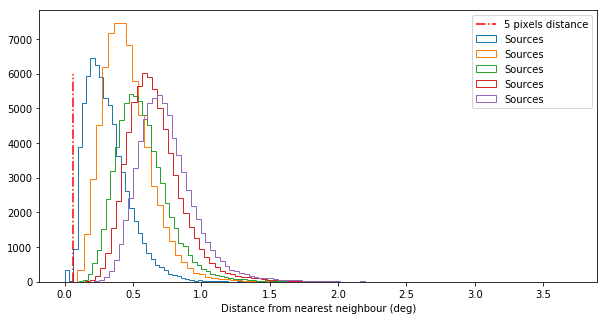

In [38]:
ax=(neighbours.dist_1).hist(bins=80, figsize=(10, 5), grid=False, histtype='step', label='Sources')
ax=(neighbours.dist_2).hist(bins=70, figsize=(10, 5), grid=False, histtype='step', label='Sources')
ax=(neighbours.dist_3).hist(bins=100, figsize=(10, 5), grid=False, histtype='step', label='Sources')
ax=(neighbours.dist_4).hist(bins=90, figsize=(10, 5), grid=False, histtype='step', label='Sources')
ax=(neighbours.dist_5).hist(bins=100, figsize=(10, 5), grid=False, histtype='step', label='Sources')
plt.plot([0.0625,0.0625],[0,6000], 'r-.', label='5 pixels distance')
plt.xlabel('Distance from nearest neighbour (deg)')
#plt.xscale('log')
plt.legend()

In [39]:
def get_linear_corr(source_id):
    lc1 = filtered_raw_data[filtered_raw_data.source_id==source_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')
    n_id = ((neighbours[neighbours.source_id == source_id]).n_id2.values[0])
    lc2 = filtered_raw_data[filtered_raw_data.source_id==n_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')
    lc1_lc2_corr = np.corrcoef(lc1_lc2['raw_peak_flux_x'], lc1_lc2['raw_peak_flux_y'])[0,1]
    return lc1_lc2_corr

In [42]:
def get_corr(source_id, n):
    if n==1:
       n_id = (neighbours[neighbours.source_id == source_id]).n_id1.values[0]
       lc2 = filtered_raw_data[filtered_raw_data.source_id==n_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')
    if n==2:
       n_id = (neighbours[neighbours.source_id == source_id]).n_id2.values[0]
       lc2 = filtered_raw_data[filtered_raw_data.source_id==n_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')   
    if n==3:
       n_id = (neighbours[neighbours.source_id == source_id]).n_id3.values[0]
       lc2 = filtered_raw_data[filtered_raw_data.source_id==n_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')
    if n==4:
       n_id = (neighbours[neighbours.source_id == source_id]).n_id4.values[0]
       lc2 = filtered_raw_data[filtered_raw_data.source_id==n_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')
    if n==5:
       n_id = (neighbours[neighbours.source_id == source_id]).n_id5.values[0]
       lc2 = filtered_raw_data[filtered_raw_data.source_id==n_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time')
    lc1 = filtered_raw_data[filtered_raw_data.source_id==source_id][['time','raw_peak_flux']].set_index('time').sort_values(by='time') 
    lc1_lc2 = (pd.merge(lc1, lc2, left_index=True, right_index=True))
    
    lc1_lc2_corr_s = lc1_lc2.corr(method='spearman').iloc[0,1]
    lc1_lc2_corr_p = lc1_lc2.corr(method='pearson').iloc[0,1]
    
    return lc1_lc2_corr_s, lc1_lc2_corr_p 

In [61]:
# Good test source ..... source_id = 12775
source_list = []
x_corr_1 = []
x_corr_2 = []
x_corr_3 = []
x_corr_4 = []
x_corr_5 = []
l_corr_1 = []
l_corr_2 = []
l_corr_3 = []
l_corr_4 = []
l_corr_5 = []

for source in stats_table.source_id: 
    source_list.append(source) 
    x1, l1 = get_corr(source, 1)
    x2, l2 = get_corr(source, 2)
    x3, l3 = get_corr(source, 3)
    x4, l4 = get_corr(source, 4)
    x5, l5 = get_corr(source, 5)
    x_corr_1.append(x1)
    l_corr_1.append(l1)
    x_corr_2.append(x2)
    l_corr_2.append(l2)
    x_corr_3.append(x3)
    l_corr_3.append(l3)
    x_corr_4.append(x4)
    l_corr_4.append(l4)
    x_corr_5.append(x5)
    l_corr_5.append(l5)

d = {'source_id':source_list,'x_corr_1':x_corr_1, 'x_corr_2':x_corr_2, 'x_corr_3':x_corr_3, 'x_corr_4':x_corr_4,'x_corr_5':x_corr_5, 'l_corr_1':l_corr_1, 'l_corr_2':l_corr_2, 'l_corr_3':l_corr_3, 'l_corr_4':l_corr_4,'l_corr_5':l_corr_5}
corr = pd.DataFrame(d)

In [64]:
stats_table = stats_table.merge(corr, left_on='source_id', right_on='source_id')

## Add a column for source density 

In [45]:
# This takes a while but works. 
#stats_table.set_index('source_id', inplace=True)
#box_size = 0.25 
#stats_table['s_density'] = stats_table.apply(lambda s: data[data.ra.between(s.ra-box_size, s.ra+box_size) & 
#                                                data.dec.between(s.dec-box_size, s.dec+box_size)]['source_id'].nunique(), axis=1)

### Save the data

In [68]:
stats_table.reset_index(inplace=True)
filtered_raw_avg_data.reset_index(inplace=True)
filtered_raw_data.reset_index(inplace=True)
neighbours.reset_index()

,index,source_id,n_id1,n_id2,n_id3,n_id4,n_id5,source_id_ra,source_id_dec,n_id1_ra,...,n_id3_dec,n_id4_ra,n_id4_dec,n_id5_ra,n_id5_dec,dist_1,dist_2,dist_3,dist_4,dist_5
0,0,3045,3140,3400,3302,3645,3288,22.932674,-70.002974,22.637308,...,-69.603542,22.477568,-69.099182,21.900402,-69.626978,0.180695,0.553926,0.473901,0.917546,0.517842
1,1,3054,3245,3184,3580,3367,3089,29.589072,-69.987369,29.118648,...,-69.207544,28.211346,-69.510528,31.236225,-69.928143,0.332296,0.428277,0.866557,0.674264,0.567508
2,2,3070,3213,3723,4106,3897,3691,352.690179,-69.952318,352.484479,...,-68.391322,351.669304,-68.675636,351.079305,-69.014292,0.219503,1.053691,1.570152,1.326419,1.094603
3,3,3081,3521,3740,3965,4183,4605,11.677428,-69.953863,11.225793,...,-68.569749,12.215364,-68.281141,11.093081,-67.774091,0.703099,1.028363,1.396887,1.683441,2.189622
4,4,3083,3220,3358,3136,3634,3974,20.446343,-69.950554,20.689724,...,-69.862155,21.114927,-69.110302,20.061765,-68.559943,0.231345,0.423317,0.314067,0.872050,1.397079
5,5,3089,3184,3663,3580,3839,3930,31.236225,-69.928143,30.683771,...,-69.207544,30.979662,-68.782196,31.965769,-68.630361,0.239238,0.863806,0.746749,1.149359,1.323007
6,6,3090,3424,3690,3706,4314,3136,17.608897,-69.915916,17.792461,...,-68.979819,18.231539,-68.082484,19.569002,-69.862155,0.494719,0.924642,1.037959,1.846697,0.675985
7,7,3091,3340,3110,3529,3701,3861,95.752976,-69.919880,96.007823,...,-69.273867,96.371277,-69.001247,95.727482,-68.740840,0.373286,0.306027,0.694977,0.943765,1.178921
8,8,3092,3862,4123,3903,3175,3847,90.402186,-69.925399,90.598827,...,-68.655155,88.133168,-69.796089,88.415279,-68.773917,1.187984,1.608487,1.383297,0.791709,1.347600
9,9,3099,3457,3135,4113,4041,4371,60.703652,-69.920189,59.917590,...,-68.388933,59.428396,-68.479946,59.960984,-68.012829,0.609038,0.354125,1.577545,1.509483,1.925608


In [69]:
stats_table.to_feather('stats_table.fth')
filtered_raw_avg_data.to_feather('avg_data.fth')
filtered_raw_data.to_feather('data.fth')
neighbours.to_feather('neighbours.fth')